In [1]:
%matplotlib notebook
import ifm3dpy
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.transform import Rotation as R

# Using Intrinsics and Unit Vectors

This Jupyter notebook demonstrates how to use the intrinsic calibration of the camera to calculate the unit vectors.

It also demonstrates how to use the unit vectors (whether they were calculated or obtained directly from the camera) to convert radial distance to cartesian information in the camera coordinate frame.


The O3D303 camera model is based on the model described in this document:
http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/parameters.html

In [2]:
# Set up the ifm3d objects and data structures
cam = ifm3dpy.Camera()
fg = ifm3dpy.FrameGrabber(cam, ifm3dpy.IMG_AMP | ifm3dpy.INTR_CAL | ifm3dpy.IMG_RDIS | ifm3dpy.IMG_CART)
im = ifm3dpy.ImageBuffer()

<IPython.core.display.Javascript object>


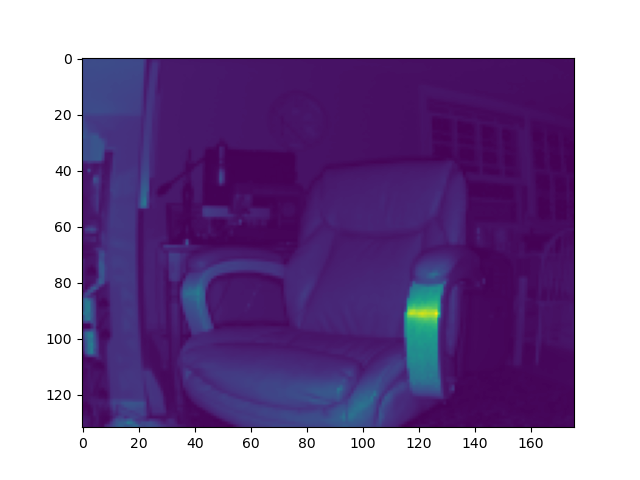

In [3]:
# Capture a frame and save references to the components
fg.wait_for_frame(im)

im_xyz = im.xyz_image()
im_rdis = im.distance_image()
im_amp = im.amplitude_image()
im_conf = im.confidence_image()

# Have a look at the scene via the amplitude image
fig = plt.figure()
plt.imshow(im_amp)

# Deriving Unit Vectors from Intrinsics

The unit vector matrix is used to determine the direction of light passing through the camera lens for each pixel in the imager array. These vectors (direction) coupled with the radial distance measurement (magnitude) combine to produce cartesian depth information (xyz).

This section will demonstrate how the unit vector matrix can be computed using the camera's intrinsic calibration parameters combined with the [camera model](http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/parameters.html) which accounts for lens distortion.

Note: It is not necessary to compute the unit vectors in application. The unit vector matrix is available pre-computed from the camera by providing the `ifm3dpy.IMG_UVEC` flag in the `ifm3dpy.FrameGrabber`. Since these unit vectors are static (but unique per camera) one may choose to cache the unit vector matrix on startup and then re-instantiate the `ifm3dpy.FrameGrabber` without including the `ifm3dpy.IMG_UVEC` flag in order to minimize network load.

<IPython.core.display.Javascript object>


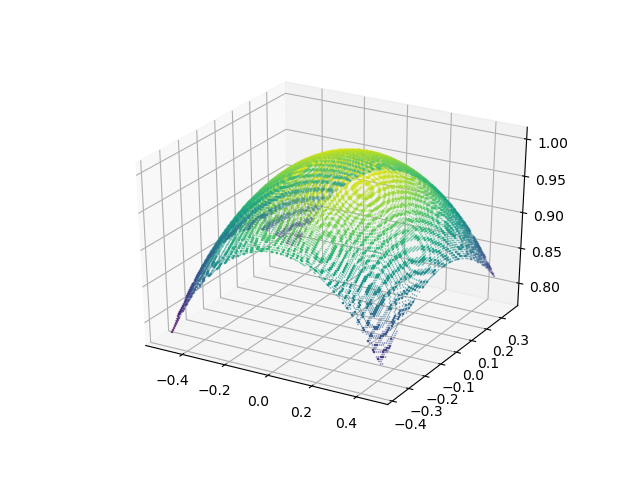

In [4]:
# Unpack intrinsics values - refer to the camera model documentation for details
fx, fy, mx, my, alpha, k1, k2, k5, k3, k4, *_ = im.intrinsics()

# Create index matrix of the imager size as a starting point
yy,xx = np.indices(im.amplitude_image().shape)

# The intrinsic information is based on the full resolution imager.
# If the current application is using the 23k imager (binning)
# the indices must be scaled up accordingly.
settings = cam.to_json()
if settings['ifm3d']['Apps'][cam.active_application() - 1]['Imager']['Resolution'] == '0':
    yy = yy * 2 + 0.5
    xx = xx * 2 + 0.5

# Re-center and scale the indices according to the principal point and focal lengths
oy = (yy + 0.5 - my)/fy
ox = (xx + 0.5 - mx)/fx

# Apply the radial and tangential distortion according to the model
ox -= alpha * oy
rd2 = oy**2 + ox**2
radial = 1 + (rd2*(k1 + (rd2*(k2 + (rd2*k5)))))
h = 2*ox*oy
tangx = (k3*h) + (k4*(rd2 + (2*ox*ox)))
tangy = (k3*(rd2 + (2*oy*oy))) + (k4*h)
dx = (ox*radial) + tangx
dy = (oy*radial) + tangy

# Populate and normalize the unit vector matrix
uv = np.zeros(im.amplitude_image().shape + (3,))
uv[:,:,0] = dx
uv[:,:,1] = dy
uv[:,:,2] = 1
uv /= np.linalg.norm(uv, axis=-1, keepdims=True)

# Plot the unit vectors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    uv[:,:,0].flatten(),
    uv[:,:,1].flatten(),
    uv[:,:,2].flatten(),
    s = 0.1,
    marker = ',',
    c = uv[:,:,2].flatten())

# Computing Cartesian Information

Now that we've derived the unit vectors from the intrinsic calibration and the camera model (or simply read out from the camera as previously discussed), we can use those unit vectors to project the radial depth into cartesian space.

The following cells illustrate the process of:
1. Combining the unit vectors and radial distance to get cartesian information
2. Performing an extrinsic calibration to warp from the sensor frame (theoretical optical center) to the camera frame (center of the glass over the lens)
3. Converting this data from the O3D303 sensor coordinate frame (right hand, z-axis out) to the ifm3d coordinate frame (right hand, x-axis out)
4. Validating that the computed cartesian data matches the pre-computed values read directly from the sensor

<IPython.core.display.Javascript object>


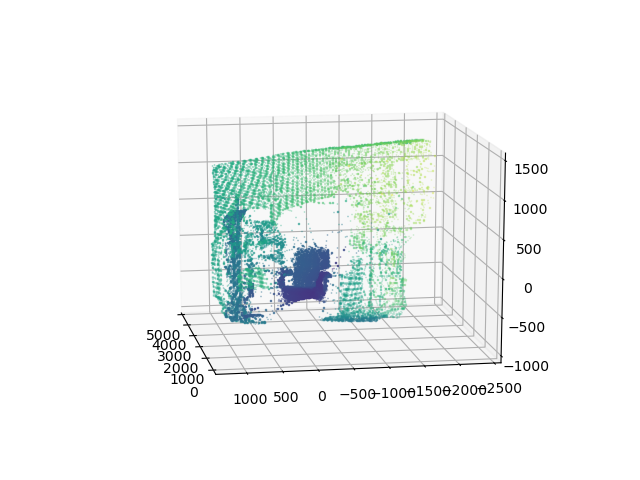

In [5]:
# 1. Apply the radial distance measurement to the unit vectors to get
# cartesian data in the imager frame
xyz_im = uv*im_rdis[...,np.newaxis]

# Reshape to a kx3 matrix for further processing
xyz_im = xyz_im.reshape((-1,3))

# 2. Use the extrinsics to warp from imager frame to camera frame
# NOTE: If the user has written custom extrinsic information to the device,
# this transformation will be included here.
im_ext = im.extrinsics() # [x y z roll pitch yaw], units are mm and deg
r = R.from_euler('xyz', im_ext[3:], degrees=True).as_matrix()
t = np.array([im_ext[0:3]]).T
xyz_camera = (r.dot(xyz_im.T) + t).T

# Invalid pixels are marked by bit zero in the confidence image.
# Their radial depth measurement is zeroed, but the extrinsic transformation
# in the previous step has induced values. Re-zero these pixels now.
mask = (im_conf.flatten() & 0x1) == 0x1
xyz_camera[mask,:] = 0

# 3. Convert to int16 and transform to ifm3d coordinate frame
x_computed = np.around(xyz_camera[:,2]).astype('int16')
y_computed = np.around(-xyz_camera[:,0]).astype('int16')
z_computed = np.around(-xyz_camera[:,1]).astype('int16')

# Render the scene
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    x_computed,
    y_computed,
    z_computed,
    s = 0.1,
    marker = ',',
    c = x_computed)

In [6]:
# 4. Check for correctness against the pre-computed values read from the sensor
#
# Reshape as an mxnx3 array to compare against the cartesian data returned
# by the camera (consider as 'truth') -- we observe a 1mm error (rounding)
xyz_computed = np.vstack((x_computed, y_computed, z_computed)).T.reshape(im_xyz.shape)
np.max(np.abs(xyz_computed - im_xyz))

1